# Bayesian Blocks for Broad Excesses (formal)

The goal of the Bayesian Blocks (BB) binning algorithm (http://arxiv.org/abs/1207.5578) is to choose optimal bin edges for a given histogram.  The optimality criterion is expressed by choosing bin edges such that the content within the bin edges is consistent with a uniform distribution, and thus any fluctuation in data values within two given bin edges is solely statistical in nature.  This binning method was initially developed for the astronomy community, in which signals appear as a uniform distribution on top of a noisy, constant background.  If the signal is statistically significant with respect to the background, then it should fall into its own bin in order to maximize a fitness metric, which is a function of the data and the binning.


## A Black Hole Simulation

We have simulated data, and a functional form used to describe that data.

First, we will set up the necessary imports and function definitions:

In [1]:
from __future__ import division
import os
import functools
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pkl
from bb.tools.hist_tools_modified import hist
from bb.tools.bb_plotter import make_fit_plot, make_bb_plot, make_bb_plot_v2, make_hist_ratio_blackhole2
import bh_comp as bh_tools
import nllfitter.future_fitter as ff
from tqdm import tqdm_notebook
from scipy.stats import norm
from collections import defaultdict

%matplotlib inline
plt.rcParams['figure.figsize'] = (12,8)

Welcome to JupyROOT 6.08/02


We will now load the Monte Carlo data, and specify the background and signal ranges.  We want the range of the BG to be 2800 to 13000 GeV.

In [ ]:
bb_dir  = os.path.join(os.path.dirname(bh_tools.__file__), '../..')
df_data_mul2 = pkl.load(open(bb_dir+'/files/BH/BH_test_data.p','rb'))
data_bg_mul2 = df_data_mul2[df_data_mul2.ST_mul2_BB>=2800].ST_mul2_BB.values

df_data_mul8 = pkl.load(open(bb_dir+'/files/BH/BH_paper_data.p','rb'))
data_bg_mul8 = df_data_mul8[df_data_mul8.ST_mul8_BB>=2800].ST_mul8_BB.values

xlimits = (2800, 13000)
x       = np.linspace(xlimits[0], xlimits[1], 10000)
nbins   = 102 # for 10 GeV histogram binning
binning = (xlimits[1]-xlimits[0])/nbins

The background function will be fit with a 3rd order Legendre polynomial, and the signal will be fit with a Gaussian distribution.  These functional forms will be used to generate background and signal MC, which will then be evaluated with the BB algorithm.  This is done to allow for an easy comparison of statistical significance between the BB and unbinned fit methods without the introduction of additional uncertainty regarding the true underlying pdfs.

In [ ]:
ax = plt.subplot()
ax.hist(data_bg_mul2, bins = 102, stacked=True, alpha=0.2, histtype='stepfilled', label='BH Data Mul 2', range=xlimits)
ax.hist(data_bg_mul8, bins = 102, stacked=True, alpha=0.2, histtype='stepfilled', label='BH Data Mul 8', range=xlimits)
plt.legend()
plt.ylabel('Counts/(100 GeV)')
plt.xlabel('ST (GeV)')
ax.set_yscale("log", nonposy='clip')
ax.set_ylim(ymin=0.1)

In [ ]:
bg_model = ff.Model(bh_tools.bg_pdf, ['alpha', 'beta', 'gamma'])
bg_model.set_bounds([(1e-20, 20), (-10, -1e-20), (1e-20, 10)])
#bg_model.set_bounds([(-200, 200), (-100,100)])
bg_fitter = ff.NLLFitter(bg_model, data_bg_mul2, min_algo='SLSQP')
bg_result = bg_fitter.fit([-1.80808e+01, -8.21174e-02, 8.06289e-01])
#bg_result = bg_fitter.fit([-1.80808e+01, 8.06289e-01])

textstr = (r'$\alpha={0:.2f}$''\n'r'$\beta={1:.2f}$''\n'r'$\gamma={2:.2f}$').format(*bg_result.x)
#textstr = ('$a_1={0:.2f}$\n$a_2={1:.2f}$').format(*bg_result.x)
ax = make_fit_plot(data_bg_mul2, 102, (2800, 13000), functools.partial(bh_tools.bg_pdf, a=bg_result.x),
        'Fit to ST Distributions', textstr = textstr, hist_label='ST Mult 2', pdf_label='Fitted PDF')
ax = make_fit_plot(data_bg_mul8, 102, (2800, 13000), functools.partial(bh_tools.bg_pdf, a=bg_result.x),
        'Fit to ST Distributions', textstr = textstr, ax=ax, hist_label='ST Mult 8', pdf_label='Rescaled PDF',
                  xlabel='ST (GeV)')
ax.set_yscale("log", nonposy='clip')
ax.set_ylim(ymin=0.00001)

In [ ]:
sig_model = ff.Model(hgg_tools.sig_pdf, ['mu', 'sigma'])
sig_model.set_bounds([(110, 130), (1, 5)])
sig_fitter = ff.NLLFitter(sig_model, data_sig)
sig_result = sig_fitter.fit([120.0, 2])

textstr = ('$\mu={0:.2f}$\n$\sigma={1:.2f}$').format(*sig_result.x)
make_fit_plot(data_sig, 80, xlimits, functools.partial(hgg_tools.sig_pdf, a=sig_result.x),
        'Fit to Delphis Signal', textstr = textstr)

## Generating MC from PDFs

We will use the functional forms defined above to create MC toys using the ROOT pdf sampling methods.  We are going to generate the same number of background and signal events as defined above, and then combine them together into a single dataset.  We can then fit that dataset with the combined background and signal pdfs, and extract a p-value and Gaussian Z-score based on the profile likelihood ratio.

In [ ]:
from ROOT import gRandom
from ROOT import TF1

gRandom.SetSeed(111)

# Set up bg sampling
bg_pdf_ROOT = functools.partial(bh_tools.bg_pdf, doROOT=True)
tf1_bg_pdf = TF1("tf1_bg_pdf", bg_pdf_ROOT, 2800, 13000, 3)
tf1_bg_pdf.SetParameters(*bg_result.x)
mc_bg = [tf1_bg_pdf.GetRandom() for i in xrange(len(data_bg_mul8))]

# Set up signal sampling
sig_pdf_ROOT = functools.partial(bh_tools.sig_pdf, doROOT=True)
tf1_sig_pdf = TF1("tf1_sig_pdf", sig_pdf_ROOT, 2800, 13000, 2)
tf1_sig_pdf.SetParameters(6000, 1200)
mc_sig = [tf1_sig_pdf.GetRandom() for i in xrange(10)]

print 'number of bg events:',len(mc_bg)
print 'number of sig events:', len(mc_sig)

mc_bg_sig = mc_bg+mc_sig

In [ ]:
ax = plt.subplot()
plt.hist([mc_bg, mc_sig], bins = 102, range=xlimits, stacked=True,
         alpha=0.2, histtype='stepfilled', label=['QCD BG', 'BH Signal'])
plt.legend()
plt.ylabel('Counts/(10 GeV)')
plt.xlabel('ST (GeV)')
ax.set_yscale("log", nonposy='clip')
ax.set_ylim(ymin=0.00001)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

bb_bc, bb_be = make_bb_plot_v2(mc_bg, 0.02, bb_dir+'/plots/', hrange=xlimits, scale='binwidth',
                title='ST Mult 8 Toy',
               xlabel=r'$S_T$ (GeV)', ylabel='Events/binwidth', save_name='bh_bg_hist', logy=True)
bb_be[-1] = bb_be[-1]+0.1
bb_be=np.append(bb_be, [13000])
bb_be[0] = 2800
#ax.set_yscale("log", nonposy='clip')
#ax.set_ylim(ymin=0.00001)

In [ ]:
mc_bg_est = [tf1_bg_pdf.GetRandom() for i in xrange(1000000)]
mc_sig_est = [tf1_sig_pdf.GetRandom() for i in xrange(1000000)]
be_100GeV = np.linspace(2800, 13000, 103)

In [ ]:
bh_tools.bh_ratio_plots(mc_bg, mc_bg_est, bb_be, title = 'Black Hole Example, Bayesian Blocks, No Signal',
                       save_name = 'bh_bb_vis_no_sig', signal_mc = mc_sig_est)
bh_tools.bh_ratio_plots(mc_bg, mc_bg_est, be_100GeV, title = 'Black Hole Example, 100 GeV Bins, No Signal',
                       save_name = 'bh_b100_vis_no_sig', signal_mc = mc_sig_est)
bh_tools.bh_ratio_plots(mc_bg_sig, mc_bg_est, bb_be, title = 'Black Hole Example, Bayesian Blocks, Injected Signal',
                       save_name = 'bh_bb_vis_inj_sig', signal_mc = mc_sig_est)
bh_tools.bh_ratio_plots(mc_bg_sig, mc_bg_est, be_100GeV, title = 'Black Hole Example, 100 GeV Bins, Injected Signal',
                       save_name = 'bh_b100_vis_inj_sig', signal_mc = mc_sig_est)

Now we will fit these distributions with the functional forms used to generate them.  We will fit with a background-only pdf and a background+signal pdf.  The ratio of the likelihood produced by these two methods will be used to calculate the significance.

In [ ]:
mc_bg_only_fitter = ff.NLLFitter(bg_model, np.asarray(mc_bg_sig))
mc_bg_only_result = mc_bg_only_fitter.fit(bg_result.x)

textstr = (r'$\alpha={0:.2f}$''\n'r'$\beta={1:.2f}$''\n'r'$\gamma={2:.2f}$').format(*mc_bg_only_result.x)
ax = make_fit_plot(mc_bg_sig, 80, xlimits, functools.partial(bh_tools.bg_pdf, a=mc_bg_only_result.x),
    'BG only model to Signal+BG Toy', textstr = textstr)
ax.set_yscale("log", nonposy='clip')
ax.set_ylim(ymin=0.00001)

In [ ]:
bg_sig_model = ff.Model(bh_tools.bg_sig_pdf, ['C', 'mu', 'sigma', 'alpha', 'beta', 'gamma'])
bg_sig_model.set_bounds([(0, 1), (5000, 5000), (1000, 1000), (mc_bg_only_result.x[0], mc_bg_only_result.x[0]),
                         (mc_bg_only_result.x[1], mc_bg_only_result.x[1]), (mc_bg_only_result.x[2],mc_bg_only_result.x[2])])
mc_bg_sig_fitter = ff.NLLFitter(bg_sig_model, np.asarray(mc_bg_sig))
mc_bg_sig_result = mc_bg_sig_fitter.fit([0.01, 5000, 1000, mc_bg_only_result.x[0], mc_bg_only_result.x[1], mc_bg_only_result.x[2]])

textstr = ('$C={0:.2f}$\n$\mu={1:.2f}$\n$\sigma={2:.2f}$\n'
          '$a_1={3:.2f}$\n$a_2={4:.2f}$\n$a_3={5:.2f}$').format(*mc_bg_sig_result.x)
ax = make_fit_plot(mc_bg_sig, 80, xlimits, functools.partial(bh_tools.bg_sig_pdf, a=mc_bg_sig_result.x),
    'Signal+BG model to Signal+BG Toy', extra_pdf_tuple=(functools.partial(bh_tools.bg_sig_pdf,
    a=np.concatenate([[0], mc_bg_sig_result.x[1:]])), 1-mc_bg_sig_result.x[0], 'bg pdf'), textstr = textstr)
ax.set_yscale("log", nonposy='clip')
ax.set_ylim(ymin=0.00001)

scan_vals = np.arange(0,0.1,0.001)
nll_vals = []
for i in tqdm_notebook(range(len(scan_vals))):
    test_model = ff.Model(bh_tools.bg_sig_pdf, ['C', 'mu', 'sigma', 'alpha', 'beta', 'gamma'])
    test_model.set_bounds([(scan_vals[i]-0.0001, scan_vals[i]+0.0001), (5000, 5000), (1000, 1000), (mc_bg_only_result.x[0], mc_bg_only_result.x[0]),
                           (mc_bg_only_result.x[1], mc_bg_only_result.x[1]), (mc_bg_only_result.x[2],mc_bg_only_result.x[2])])
    test_fitter = ff.NLLFitter(test_model, np.asarray(mc_bg_sig), verbose=False)
    test_result = test_fitter.fit([scan_vals[i], 5000, 1000, mc_bg_only_result.x[0], mc_bg_only_result.x[1], mc_bg_only_result.x[2]])
    nll_vals.append(test_result.fun)
    


In [ ]:
print nll_vals

Now that we have fit the distribution with both a bg-only and a bg+signal pdf, we can compare the two likelihoods in the following way:
$$\lambda(\mu)=\frac{L(\mu,\hat{\hat{\boldsymbol{\theta}}})}{L(\hat{\mu},\hat{\boldsymbol{\theta}})}$$
where $\mu=0$ (representing the background-only hypothesis), and $\hat{\mu}$ is a free parameter, determined by the fitting procedure.  We can then use then construct the test statistic $q_0$ for discovering a new signal:
$$q_{\mu} = \left\{ \begin{array}{ll} -2\ln\lambda(\mu) & \quad \hat{\mu} \leq \mu, \\ 0 & \quad \hat{\mu} > \mu \end{array} \right.$$
Assuming the Wald approximation holds (https://arxiv.org/abs/1007.1727), the pdf of $q_0$ for a given $\mu$ can be represented by a $\frac{1}{2}\chi^2$ distribution of 1 degree of freedom, and the CDF of that distribution is:
$$F(q_{\mu}|\mu)=\Phi(\sqrt{q_\mu})$$
The p-value is:
$$p_\mu = 1-F(q_{\mu}|\mu) = 1-\Phi(\sqrt{q_\mu})$$

A 95% UL can be found as the value of $\mu$ for which $p_\mu = \alpha$, and $\alpha = 0.05$.

In [ ]:
from IPython.display import HTML
nll_bg  = mc_bg_only_result.fun
nll_sig = mc_bg_sig_result.fun
print mc_bg_sig_result.x
p_vals = []
qus = []
for val in nll_vals:
    qu = 2*max(val-nll_sig, 0)
    pval = 1-norm.cdf(qu)
    #print pval
    p_vals.append(pval)
    qus.append(qu)
#q0= 2*max(nll_bg-nll_sig,0)
#HTML('<h3><b>Significance of peak from nll fit: {0:.3f} sigma</b></h3>'.format(np.sqrt(q0)))
for i,p in enumerate(p_vals):
    if np.isclose(p, 0.05, 0.002, 0.002):
        print i, p

fig, ax1 = plt.subplots()
ax1.plot(scan_vals, qus, 'b')
ax1.set_xlabel('signal strengths ($\mu$)')
ax1.set_ylabel('$q_\mu$', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(scan_vals, p_vals, 'r')
ax2.set_ylabel('p-values', color='r')
ax2.tick_params('y', colors='r')
ax2.plot(scan_vals[48], p_vals[48], 'k*')
ax2.annotate('95% CL', xy=(0.048, 0.05), xytext=(0.06, 0.15),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.title('Test-statistic and p-values for signal Mass=5000, Width=1000 GeV')




## Using Bayesian Blocks Binning to Produce Confidence Intervals

We will repeat the above procedure for many toys, and produce the typical banana plot that is common for LHC limit setting across multiple signal masses.

* Generate initial fit to bg simulation.
* Produce toys from that fit.
* Determine mass points.
* Fit each toy with each mass point, allowing signal strength to fluctuate.
* Calculate the 95% CL signal strength for each toy, for each mass point, by scanning the signal strength.
* Make banana plot.

**Bonus**
* Instead of using $q_\mu$, use an ensample of best fits to toys to determine 95%CL on signal strength.


In [ ]:
class SignalHolder(object):
    def __init__(self):
        self.mass = None
        self.mle_res = None
        self.scan_res = None

class ToyHolder(object):
    def __init__(self, data):
        self.data = data
        self.signals = []
        

In [ ]:
bb_dir  = os.path.join(os.path.dirname(bh_tools.__file__), '../..')
df_data_mul2 = pkl.load(open(bb_dir+'/files/BH/BH_test_data.p', 'rb'))
data_bg_mul2 = df_data_mul2[df_data_mul2.ST_mul2_BB >= 2800].ST_mul2_BB.values

df_data_mul8 = pkl.load(open(bb_dir+'/files/BH/BH_paper_data.p', 'rb'))
data_bg_mul8 = df_data_mul8[df_data_mul8.ST_mul8_BB >= 2800].ST_mul8_BB.values

bg_result, n_bg, be_bg = bh_tools.generate_initial_params(data_bg_mul2, data_bg_mul8)



In [ ]:
n_toys = 300
toys = []

signal_params = [(4000, 800), (5000, 1000), (6000, 1200), (7000, 1400)]
bg_sig_model = ff.Model(bh_tools.bg_sig_pdf, ['C', 'mu', 'sigma', 'alpha', 'beta', 'gamma'])

for i in tqdm_notebook(xrange(n_toys), desc='Toy Data'):
    toy = ToyHolder(bh_tools.generate_toy_data(bg_result.x, n_bg, seed=i))
    for params in tqdm_notebook(signal_params, leave=False, desc='Signal Models'):
        signal = SignalHolder()
        signal.mass = params[0]
        bg_sig_model.set_bounds([(0, 1), (params[0], params[0]), (params[1], params[1]), (mc_bg_only_result.x[0], mc_bg_only_result.x[0]),
                                 (mc_bg_only_result.x[1], mc_bg_only_result.x[1]), (mc_bg_only_result.x[2],mc_bg_only_result.x[2])])
        mle_fitter = ff.NLLFitter(bg_sig_model, np.asarray(toy.data), verbose=False)
        signal.mle_res = mle_fitter.fit([0.01, params[0], params[1],
                                         mc_bg_only_result.x[0], mc_bg_only_result.x[1], mc_bg_only_result.x[2]], calculate_corr=False)
        pval = -1
        right = 1
        left = signal.mle_res.x[0]
        mu = 0.5*(left+right)
        while not np.isclose(pval, 0.05, 0.001, 0.001):
            bg_sig_model.set_bounds([(mu*(1-1e-6), mu*(1+1e-6)), (params[0], params[0]),
                                     (params[1], params[1]), (mc_bg_only_result.x[0], mc_bg_only_result.x[0]),
                                 (mc_bg_only_result.x[1], mc_bg_only_result.x[1]), (mc_bg_only_result.x[2],mc_bg_only_result.x[2])])
            scan_fitter = ff.NLLFitter(bg_sig_model, np.asarray(toy.data), verbose=False)
            scan_res = scan_fitter.fit([mu, params[0], params[1], mc_bg_only_result.x[0],
                                        mc_bg_only_result.x[1], mc_bg_only_result.x[2]], calculate_corr=False)
            #do pval
            qu = 2*max(scan_res.fun-signal.mle_res.fun, 0)
            pval = 1-norm.cdf(qu)
            if pval<0.05:
                right = mu
                mu = 0.5*(right+left)
            else:
                left = mu
                mu = 0.5*(right+left)        
    
        signal.scan_res = scan_res
        toy.signals.append(signal)
    toys.append(toy)

In [ ]:
mean_95 = [0,0,0,0]
ensamble_95 = [[],[],[],[]]
masses = [4000, 5000, 6000, 7000]
for toy in toys:
    for i, signal in enumerate(toy.signals):
        mean_95[i] += signal.scan_res.x[0]
        ensamble_95[i].append(signal.mle_res.x[0])
for i in range(len(mean_95)):
    mean_95[i] /= float(len(toys))
    ensamble_95[i] = sorted(ensamble_95[i])[int(len(ensamble_95[i])*0.95)+1]


In [ ]:
plt.plot(masses, mean_95, label='Asymptotic Method')
plt.plot(masses, ensamble_95, label='Ensamble Method')
plt.title('95% UL on Signal Strength')
plt.ylabel('Signal Strength ($\mu$)')
plt.xlabel('Signal Mass (GeV)')
plt.legend()

In [ ]:
mean_95

In [ ]:
import warnings
warnings.filterwarnings("ignore")

_, _ = make_bb_plot(mc_bg_sig, 0.02, bb_dir+'/plots/', range=xlimits, scale='binwidth',
                title='Naive BB binning for Combined Distribution',
               xlabel=r'$m_{\gamma\gamma}$ (GeV)', ylabel='Events/binwidth', save_name='hgg_bg_hist', bins=102)
ax = plt.gca()
ax.set_yscale("log", nonposy='clip')
ax.set_ylim(ymin=0.00001)
bc_bg, be_bg = make_bb_plot(mc_bg, 0.02, bb_dir+'/plots/', range=xlimits, scale='binwidth',
                title='BB binning for Background Distribution',
               xlabel=r'$m_{\gamma\gamma}$ (GeV)', ylabel='Events/binwidth', save_name='hgg_bg_hist', bins=102)
ax = plt.gca()
ax.set_yscale("log", nonposy='clip')
ax.set_ylim(ymin=0.00001)
bc_sig, be_sig = make_bb_plot(mc_sig, 0.02, bb_dir+'/plots/', range=xlimits, scale='binwidth',
                title='BB binning for Signal Distribution',
                 xlabel=r'$m_{\gamma\gamma}$ (GeV)', ylabel='Events/binwidth', save_name='hgg_sig_hist', bins=102)
ax = plt.gca()
ax.set_yscale("log", nonposy='clip')
ax.set_ylim(ymin=0.00001)


In [ ]:
tqdm._tqdm_notebook.tqdm_notebook?

## Running Many Toys

In the following comparison, we will repeat the previous studies for many toys, then compare the average significance for both the nll fit and bayesian block methods.

In [74]:
%run bh_comp.py

Performing fit with initial parameters:
alpha	= -18.081
beta	= -0.082
gamma	= 0.806
Fit finished with status: 0
Calculating covariance of parameters...


RESULTS
-------
[ 8.521 -10.     1.696] [   nan    nan  0.066]
alpha	= 8.521 +/- nan
beta	= -10.000 +/- nan
gamma	= 1.696 +/- 0.066


CORRELATION MATRIX
------------------
[[ nan  nan  nan]
 [ nan  nan  nan]
 [ nan  nan   1.]]


[  2800.      2931.514   3376.249   3901.082   5345.291  13000.   ]



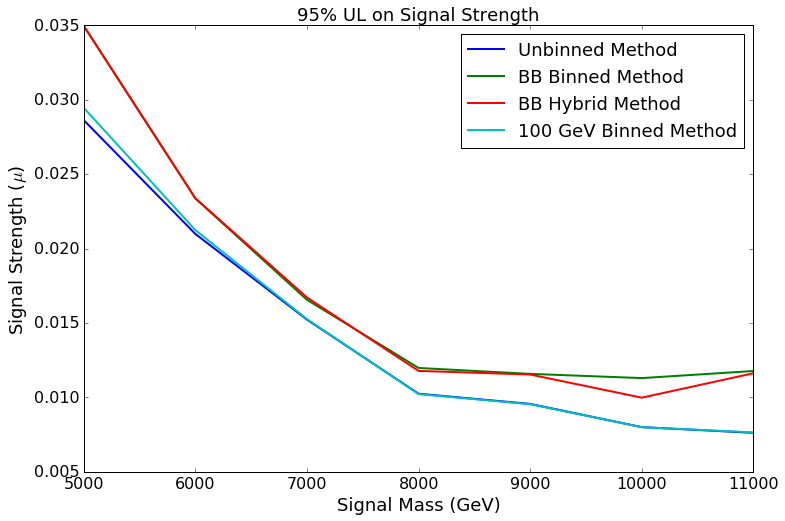

In [75]:
masses = [5000, 6000, 7000, 8000, 9000, 10000, 11000]
plt.plot(masses, [mean(i) for i in unbinned_A], label='Unbinned Method', linewidth=2)
plt.plot(masses, [mean(i) for i in binned_A], label='BB Binned Method', linewidth=2)
plt.plot(masses, [mean(i) for i in binned_A_hybrid], label='BB Hybrid Method', linewidth=2)

#plt.plot(masses, [mean(i) for i in binned_A_50], label='50 GeV Binned Method')
plt.plot(masses, [mean(i) for i in binned_A_100], label='100 GeV Binned Method', linewidth=2)
#plt.plot(masses, [mean(i) for i in binned_A_200], label='200 GeV Binned Method')
#plt.plot(masses, [mean(i) for i in binned_A_400], label='400 GeV Binned Method')
#plt.plot(masses, [mean(i) for i in binned_A_1000], label='1000 GeV Binned Method', linewidth=2)

plt.title('95% UL on Signal Strength')
plt.ylabel('Signal Strength ($\mu$)')
plt.xlabel('Signal Mass (GeV)')
plt.legend()
#plt.yscale('log')
#plt.ylim(0.01, 0.04)


In [76]:
be_hybrid, be_bg, be_sig

(array([  2800.   ,   2931.514,   3376.249,   3901.082,   3915.721,
          5345.291,  10404.152,  13000.   ]),
 array([  2800.   ,   2931.514,   3376.249,   3901.082,   5345.291,  13000.   ]),
 array([  3915.721,  10404.152]))

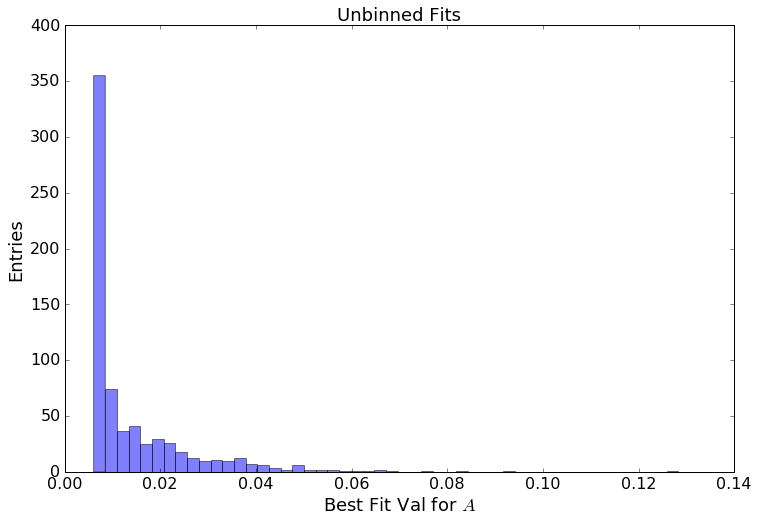

In [70]:
plt.hist(unbinned_A[1], bins=50, alpha=0.5)
plt.xlabel('Best Fit Val for $A$')
plt.ylabel('Entries')
#plt.hist(binned_A_100[2], bins=50, alpha=0.5)
#plt.hist(unbinned_A[0], bins=50, alpha=0.5)
plt.title('Unbinned Fits')


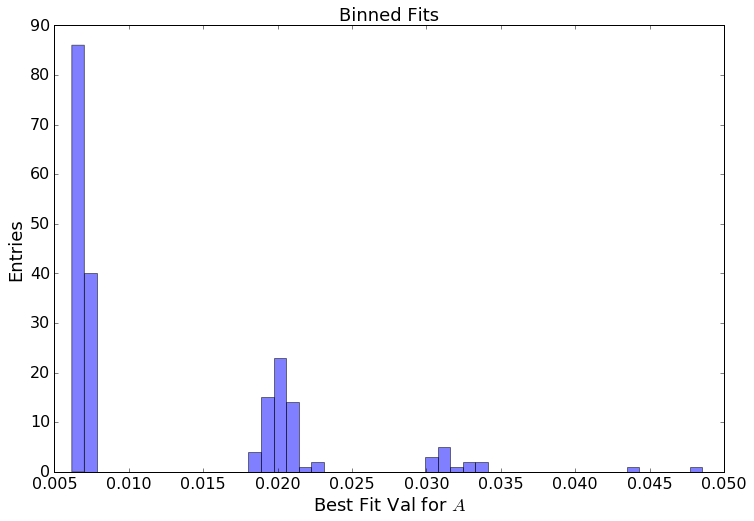

In [60]:
plt.hist(binned_A[3], bins=50, alpha=0.5)
plt.xlabel('Best Fit Val for $A$')
plt.ylabel('Entries')
#plt.hist(binned_A_100[2], bins=50, alpha=0.5)
#plt.hist(unbinned_A[0], bins=50, alpha=0.5)
plt.title('Binned Fits')

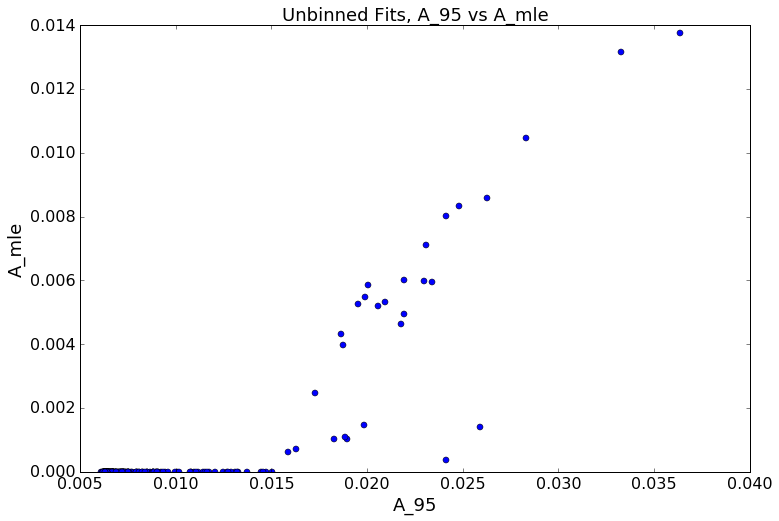

In [46]:
plt.plot(unbinned_A[3], unbinned_A_mle[3], 'bo')
plt.xlabel('A_95')
plt.ylabel('A_mle')
plt.title('Unbinned Fits, A_95 vs A_mle')

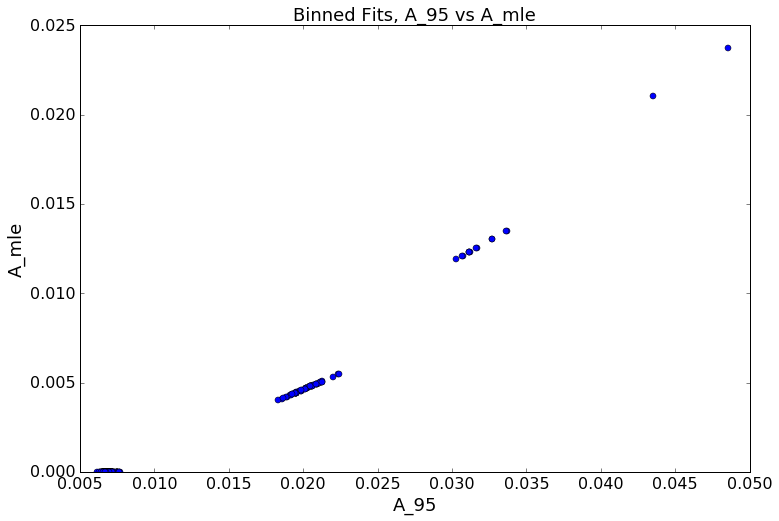

In [45]:
plt.plot(binned_A[3], binned_A_mle[3], 'bo')
plt.xlabel('A_95')
plt.ylabel('A_mle')
plt.title('Binned Fits, A_95 vs A_mle')

In [71]:
a = [[]]*len(sig_params)

In [73]:
binned_A

[[0.012397527694702148,
  0.029662370681762695,
  0.053468692251472341,
  0.079197887287418361,
  0.051060770420865598,
  0.034004572463554872,
  0.078143820300262817,
  0.038448793099327534,
  0.063516583207845145,
  0.082294532948612331,
  0.015925168991089013,
  0.013941764831543187,
  0.014972209930419922,
  0.010405421257019487,
  0.020469903945922852,
  0.021190941679235756,
  0.039986548408129402,
  0.018031001091003418,
  0.041904557425731882,
  0.051771860682826826,
  0.01823377609252947,
  0.041952610078999017,
  0.022824764251708984,
  0.018451690673828125,
  0.04350679675494161,
  0.068462478585736272,
  0.011100292205810547,
  0.024622341352844239,
  0.014531254768371683,
  0.020817279815673828,
  0.04887244369697552,
  0.012918710708618806,
  0.011597514152526855,
  0.029662370681762695,
  0.049209906728177384,
  0.039644527749501168,
  0.026849118674490764,
  0.13811235616951809,
  0.036997079896893298,
  0.019069790840148926,
  0.011682987213134766,
  0.0440144538879394